In [2]:
!pip install terratorch rasterio


In [1]:
import rasterio
import numpy as np

with rasterio.open('/content/history_patch_allbands_summer_2.tif') as src:
    img = src.read()  # shape: (12, 224, 224)


In [2]:
print(img.shape)  # Should be (12, 224, 224) – adjust if patch/tile size differs


(12, 289, 289)


In [3]:
img = np.expand_dims(img, axis=0)  # Now shape is (1, 12, 224, 224)


In [4]:
import torch
img_tensor = torch.from_numpy(img).float()


In [5]:
from terratorch import FULL_MODEL_REGISTRY

gen_model = FULL_MODEL_REGISTRY.build(
    'terramind_v1_large_generate',      # Or use '_tim_generate' for TIM variant
    pretrained=True,
    modalities=['S2L2A'],
    output_modalities=['S2L2A'],
    timesteps=10,
    standardize=True
)


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [9]:
import torch.nn.functional as F

# Calculate padding needed to make dimensions divisible by 32
# Current shape is (1, 12, 289, 289)
# Target shape needs to be (1, 12, H_new, W_new) where H_new and W_new are divisible by 32
# Smallest multiple of 32 >= 289 is 320 (32 * 10)
target_dim = 320
pad_h = target_dim - img_tensor.shape[2] # 320 - 289 = 31
pad_w = target_dim - img_tensor.shape[3] # 320 - 289 = 31

# Pad the image tensor symmetrically
# Padding is applied as (pad_left, pad_right, pad_top, pad_bottom)
# We want to pad the height and width dimensions (last two dimensions)
pad_left = pad_w // 2
pad_right = pad_w - pad_left
pad_top = pad_h // 2
pad_bottom = pad_h - pad_top

padded_img_tensor = F.pad(img_tensor, (pad_left, pad_right, pad_top, pad_bottom))

print(f"Original image tensor shape: {img_tensor.shape}")
print(f"Padding (left, right, top, bottom): ({pad_left}, {pad_right}, {pad_top}, {pad_bottom})")
print(f"Padded image tensor shape: {padded_img_tensor.shape}")


# Now pass the padded tensor to the model
# The model output shape will depend on the model's architecture and task
# For a generative model, it might output an image of the same or similar size
result = gen_model(S2L2A=padded_img_tensor)

# The output is likely a dictionary or a list. Let's inspect the keys/structure if it's a dictionary.
# Assuming the output for S2L2A generation is under the key 'S2L2A'
if isinstance(result, dict) and 'S2L2A' in result:
    generated_output_tensor = result['S2L2A']
    print(f"Generated output tensor shape: {generated_output_tensor.shape}")

    # The generated output will have the padded dimensions (1, 12, 320, 320)
    # If you need the output corresponding to the original image size (289x289),
    # you would need to crop the padded output.
    # For now, let's work with the padded output.

    # Example: get the first image from the batch and remove the batch dimension
    generated_image = generated_output_tensor[0] # Shape (12, 320, 320)

    # If you need to crop back to original size (289x289)
    # cropped_generated_image = generated_image[:, pad_top:pad_top+img_tensor.shape[2], pad_left:pad_left+img_tensor.shape[3]] # Shape (12, 289, 289)
    # print(f"Cropped generated image shape: {cropped_generated_image.shape}")

    # You can now proceed to visualize or further process the generated_image or cropped_generated_image
    # The next cell (MZuVUhtkj2YT) attempts to visualize an RGB image.
    # We need to make sure the visualization code can handle the 12 channels and potentially the padded size.
    # The original visualization code assumes a shape like (12, 224, 224) and selects channels [3,2,1].
    # We will update the next cell to handle the padded size and the 12 channels correctly for visualization.

else:
    print("Model output is not a dictionary with 'S2L2A' key or has an unexpected structure.")
    print(f"Model output type: {type(result)}")
    print(f"Model output content (first few elements/keys): {list(result.keys()) if isinstance(result, dict) else str(result)[:100]}") # Print keys for dict, or start of string for others


# Store the generated image tensor for the next visualization step
# Using the padded generated image for now
cloudfree_patch = generated_image # Shape (12, 320, 320)

Original image tensor shape: torch.Size([1, 12, 289, 289])
Padding (left, right, top, bottom): (15, 16, 15, 16)
Padded image tensor shape: torch.Size([1, 12, 320, 320])
Generated output tensor shape: torch.Size([1, 12, 320, 320])


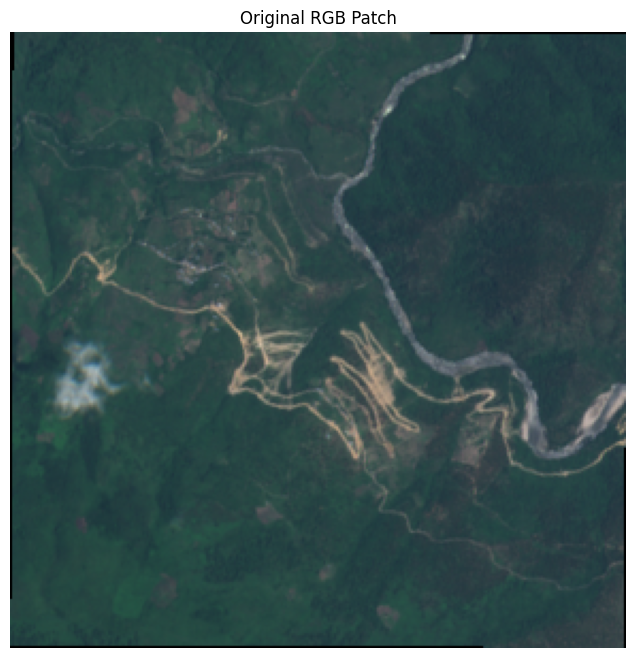

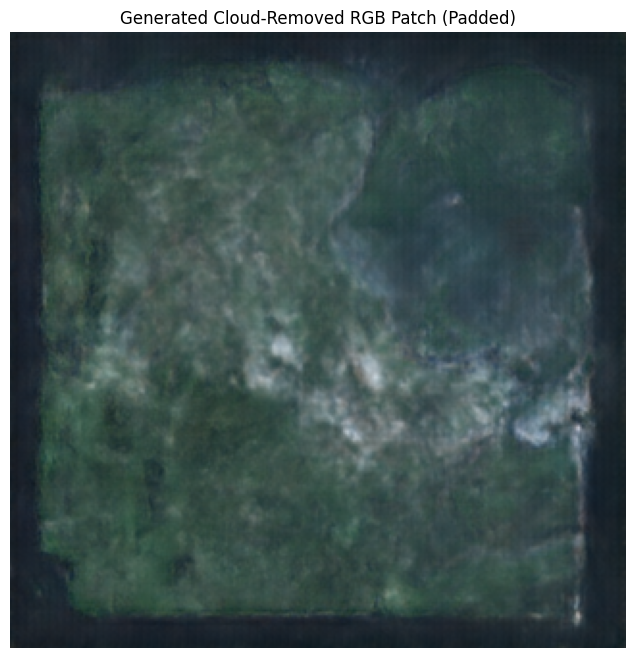

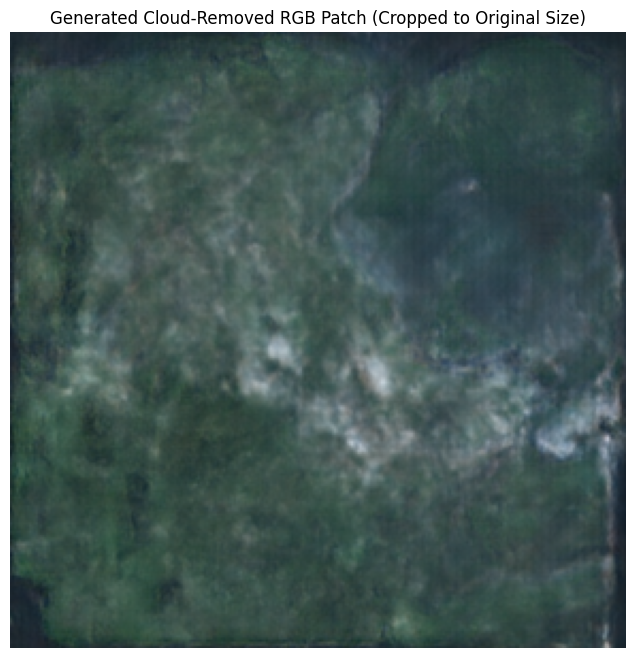

In [11]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy if not already imported
import torch # Import torch if not already imported

# The generated_image (cloudfree_patch) has shape (12, 320, 320)
# Original image size was 289x289
# Padding applied was pad_left=15, pad_right=16, pad_top=15, pad_bottom=16

# --- Visualize the original image ---
# The original image tensor is stored in the variable 'img_tensor'
# Its shape is (1, 12, 289, 289)
# Select RGB channels (B4, B3, B2 are channels 3, 2, 1 for S2L2A)
# Transpose to (H, W, C) and convert to numpy
original_rgb = img_tensor[0, [3,2,1], :, :].cpu().numpy().transpose(1,2,0)

# Apply the same simple scaling as for the generated images for comparison
original_rgb = np.clip(original_rgb / 3000, 0, 1) # Scale by a factor (e.g., 3000) and clip

plt.figure(figsize=(8, 8))
plt.imshow(original_rgb)
plt.title('Original RGB Patch')
plt.axis('off')
plt.show()


# --- Visualize the padded generated image ---
# Select RGB channels (B4, B3, B2 are channels 3, 2, 1 for S2L2A)
# Make sure to handle potential negative values or scale the data if needed for display
# For visualization, it's often good practice to clip values or normalize if they are outside 0-1 or 0-255 range.
# Assuming the generated output is in a similar range to the input reflectance values (e.g., 0-10000 or 0-1).
# Let's assume values are roughly in the 0-10000 range for scaling.
rgb_padded = cloudfree_patch[[3,2,1], :, :].cpu().numpy().transpose(1,2,0)

# Simple scaling for visualization - adjust as needed
rgb_padded = np.clip(rgb_padded / 3000, 0, 1) # Scale by a factor (e.g., 3000) and clip

plt.figure(figsize=(8, 8))
plt.imshow(rgb_padded)
plt.title('Generated Cloud-Removed RGB Patch (Padded)')
plt.axis('off')
plt.show()


# --- Optionally: Crop and Visualize the generated image to the original size ---
# Get the original image dimensions (assuming img_tensor still holds the original tensor before padding)
# If not, use the known original dimensions (289, 289)
original_h, original_w = 289, 289 # Assuming these are the original dimensions

# Calculate crop coordinates based on padding
# Padded size is 320x320
# pad_top = 15, pad_left = 15
crop_top = pad_top
crop_bottom = pad_top + original_h # 15 + 289 = 304
crop_left = pad_left
crop_right = pad_left + original_w # 15 + 289 = 304


# Crop the generated image tensor
cropped_generated_image_tensor = cloudfree_patch[:, crop_top:crop_bottom, crop_left:crop_right] # Shape (12, 289, 289)

# Prepare cropped image for visualization (select RGB, transpose, scale)
rgb_cropped = cropped_generated_image_tensor[[3,2,1], :, :].cpu().numpy().transpose(1,2,0)

# Simple scaling for visualization - adjust as needed
rgb_cropped = np.clip(rgb_cropped / 3000, 0, 1) # Scale by a factor (e.g., 3000) and clip


plt.figure(figsize=(8, 8))
plt.imshow(rgb_cropped)
plt.title('Generated Cloud-Removed RGB Patch (Cropped to Original Size)')
plt.axis('off')
plt.show()